In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from pathlib import Path 
import glob
import os
from rdkit import DataStructs
import sys
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from rdkit.Chem import Draw, Descriptors, RDConfig
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer as sa
from syba.syba import SybaClassifier, SmiMolSupplier
from scscore.scscore.standalone_model_numpy import SCScorer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
path = 'data/balanced_data'
files = Path(path).glob('*.csv') 

In [3]:
all_files = glob.glob(os.path.join(path , "*.csv"))
frames = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    frames.append(df)
df = pd.concat(frames, axis=0, ignore_index=True)

In [4]:
df = df.drop_duplicates(subset = ['target'])
df = df[df.number_of_steps <= 10]
df = df[df.number_of_steps > 0]
df = df.reset_index(drop=True)
len(df) # 15918  

15918

<AxesSubplot:>

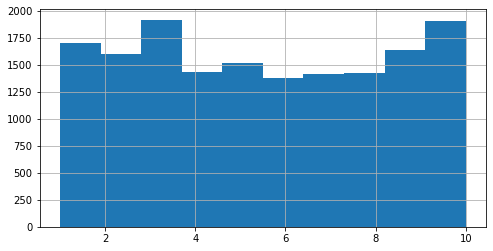

In [5]:
plt.figure(figsize=(8,4))
df.number_of_steps.hist() 

In [6]:
df['steps_bins'] = pd.cut(df['number_of_steps'], [0,1,3,6,10], labels=False) #, labels=False
df.steps_bins.value_counts()

3    6378
2    4324
1    3514
0    1702
Name: steps_bins, dtype: int64

In [7]:
df['steps_bins2'] = pd.cut(df['number_of_steps'], [0,2,4,7,10], labels=False) #, labels=False
df.steps_bins2.value_counts()
# 1,2 ; 3,4 ; 5,6,7 ; 8,9,10

3    4964
2    4303
1    3351
0    3300
Name: steps_bins2, dtype: int64

In [8]:
sc = SCScorer()
sc.restore(os.path.join('/home/zumrovad/DP/scscore',
                        'models', 'full_reaxys_model_1024bool', 'model.ckpt-10654.as_numpy.json.gz'))
# (r'C:\Users\domiz\Documents\Python\DP\scscore', 'models', 'full_reaxys_model_1024bool', 'model.ckpt-10654.as_numpy.json.gz'))
sy = SybaClassifier()
sy.fitDefaultScore()

Restored variables from /home/zumrovad/DP/scscore/models/full_reaxys_model_1024bool/model.ckpt-10654.as_numpy.json.gz


In [9]:
syba = [sy.predict(smile) for smile in df.target]
df = df.assign(syba=syba)
sascore = [sa.calculateScore(Chem.MolFromSmiles(smile)) for smile in df.target]
df = df.assign(sascore=sascore)
scscore = [sc.get_score_from_smi(smile)[1] for smile in df.target]
df = df.assign(scscore=scscore)

In [10]:
mols = [Chem.MolFromSmiles(m) for m in df.target]
df = df.assign(mol=mols)

In [11]:
df['MolWt'] = df.mol.apply(Descriptors.MolWt)
df['MolLogP'] = df.mol.apply(Descriptors.MolLogP)
df['NumHAccept'] = df.mol.apply(Descriptors.NumHAcceptors)
df['NumHDonors'] = df.mol.apply(Descriptors.NumHDonors)

<Figure size 1080x1080 with 0 Axes>

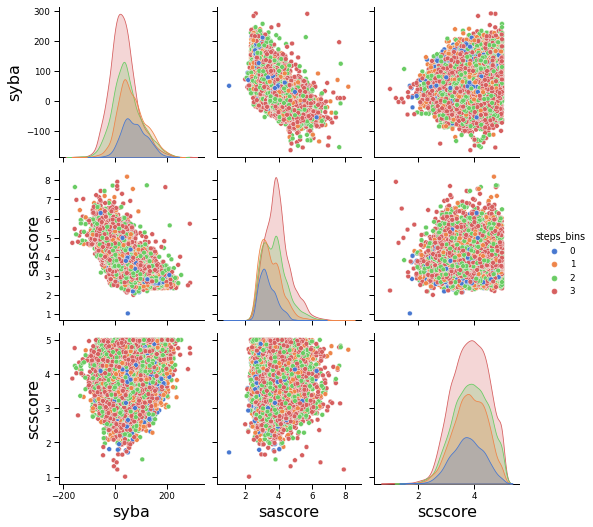

In [210]:
plt.figure(figsize=(15,15))
#sns.set_context("notebook", rc={"axes.labelsize": 16}) #"poster", font_scale=1.1
sns.pairplot(df[['steps_bins', 'syba', 'sascore', 'scscore']], hue='steps_bins', palette = 'muted') #height=2
#plt.savefig("set_context_notebook_Seaborn_pairplot.png", format='png',dpi=150)

<Figure size 1080x1080 with 0 Axes>

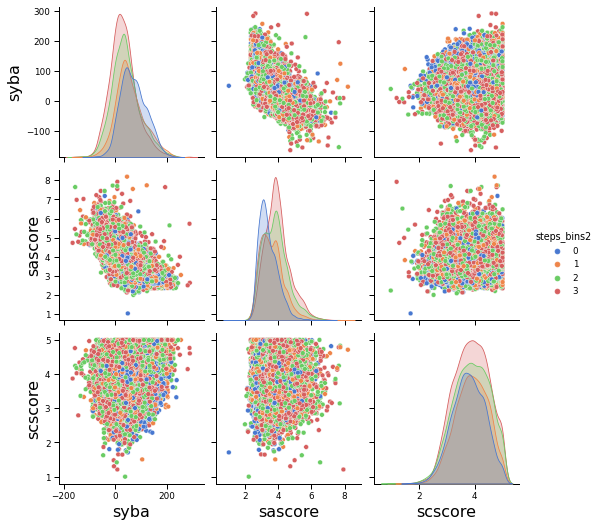

In [289]:
plt.figure(figsize=(15,15))
#sns.set_context("notebook", rc={"axes.labelsize": 16}) #"poster", font_scale=1.1
sns.pairplot(df[['steps_bins2', 'syba', 'sascore', 'scscore']], hue='steps_bins2', palette = 'muted') #height=2

In [195]:
filepath = Path('data/7Mfinal_data.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath, index=False) 

# Scaffold filter

In [12]:
all_mols = [Chem.MolFromSmiles(smile) for smile in df.target]
#df['mol'] = all_mols
df["scaf1"] = df['mol'].apply(MurckoScaffold.GetScaffoldForMol)
df["scaf2"] = df['scaf1'].apply(MurckoScaffold.MakeScaffoldGeneric)
df["scaf3"] = df['scaf2'].apply(MurckoScaffold.GetScaffoldForMol)
df["scaf3_smiles"] = df['scaf3'].apply(Chem.MolToSmiles)

In [13]:
df_1 = df[df.number_of_steps == 1]
scaf_count_1 = df_1['scaf3_smiles'].value_counts()
scaf_count_1 = pd.DataFrame(scaf_count_1)
scaf_count_1['scaffold'] = scaf_count_1.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))
scaf_count_1["prob"] = scaf_count_1["scaf3_smiles"].apply(lambda x: float(x)/len(df_1))

df_2 = df[df.number_of_steps <= 3]
df_2 = df_2[df_2.number_of_steps >= 2]
scaf_count_2 = df_2['scaf3_smiles'].value_counts()
scaf_count_2 = pd.DataFrame(scaf_count_2)
scaf_count_2['scaffold'] = scaf_count_2.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))
scaf_count_2["prob"] = scaf_count_2["scaf3_smiles"].apply(lambda x: float(x)/len(df_2))

df_6 = df[df.number_of_steps <= 6]
df_6 = df_6[df_6.number_of_steps > 3]
scaf_count_6 = df_6['scaf3_smiles'].value_counts()
scaf_count_6 = pd.DataFrame(scaf_count_6)
scaf_count_6['scaffold'] = scaf_count_6.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))
scaf_count_6["prob"] = scaf_count_6["scaf3_smiles"].apply(lambda x: float(x)/len(df_6))

df_10 = df[df.number_of_steps > 6]
scaf_count_10 = df_10['scaf3_smiles'].value_counts()
scaf_count_10 = pd.DataFrame(scaf_count_10)
scaf_count_10['scaffold'] = scaf_count_10.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))
scaf_count_10["prob"] = scaf_count_10["scaf3_smiles"].apply(lambda x: float(x)/len(df_10))

In [14]:
smil0 = scaf_count_1.reset_index()
smil0['group'] = 0
smil1 = scaf_count_2.reset_index()
smil1['group'] = 1
smil2 = scaf_count_6.reset_index()
smil2['group'] = 2
smil3 = scaf_count_10.reset_index()
smil3['group'] = 3

In [15]:
def scaffold_filter(smil0, smil1, group0, group1, df):
    treshold_head = 1.7 # 1.5, 1.8, 2, 3,5
    treshold_tail = 0.59 # 0.67, 0.56, 0,5 0.33, 0.2
    scaffolds_merge = smil0.merge(smil1, left_on='index', right_on='index')
    scaffolds_merge["prob_ratio"] = scaffolds_merge['prob_x'] / scaffolds_merge['prob_y'] 
    scaffolds_merge.sort_values(by=['prob_ratio'], ascending=False, inplace=True)
    idx = []
    for i in scaffolds_merge[scaffolds_merge['prob_ratio'] < treshold_tail]['index']:
        ids = df.index[df.steps_bins == group0][df[df.steps_bins == group0].scaf3_smiles == i].tolist()
        for i in ids:
            idx.append(i)
    for i in scaffolds_merge[scaffolds_merge['prob_ratio'] > treshold_head]['index']:
        ids = df.index[df.steps_bins == group1][df[df.steps_bins == group1].scaf3_smiles == i].tolist()
        for i in ids:
            idx.append(i)
    return idx

In [16]:
df_new = df
df_new = df_new.drop(df_new.index[scaffold_filter(smil0, smil1, 0, 1, df)])
df_new = df_new.reset_index(drop=True)
df_new = df_new.drop(df_new.index[scaffold_filter(smil1, smil2, 1, 2, df_new)])
df_new = df_new.reset_index(drop=True)
df_new = df_new.drop(df_new.index[scaffold_filter(smil2, smil3, 2, 3, df_new)])
df_new = df_new.reset_index(drop=True)
df_new = df_new.drop(df_new.index[scaffold_filter(smil0, smil3, 0, 3, df_new)])
df_new = df_new.reset_index(drop=True)
df_new = df_new.drop(df_new.index[scaffold_filter(smil1, smil3, 1, 3, df_new)])
df_new = df_new.reset_index(drop=True)
df_new = df_new.drop(df_new.index[scaffold_filter(smil0, smil2, 0, 2, df_new)])

In [17]:
len(df) - len(df_new) # 2 1930 ; 1,5 2961

2492

# Similarity filter

In [225]:
def similarity_search(df, f): 
    sim = [DataStructs.FingerprintSimilarity(x, f) for x in df.finger]
    return sim
def similarity(df):
    distance_matrix = []
    for i in range(0,len(df)):
        s = similarity_search(df, df.finger[i])
        distance_matrix.append(s)
    return distance_matrix
def group_similarity(df):
    mean = []
    std = []
    for fps in df.finger:
        a = similarity_search(df, fps)
        mean.append(np.mean(a))
        std.append(np.std(a))
    new_df = df.assign(mean = mean, std = std)
    return new_df

In [238]:
fingers = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024) for m in df_new.mol]
df_new['finger'] = fingers

In [239]:
df_0 = df_new[df_new.steps_bins == 0]
df_0 = df_0.reset_index(drop = True)
df_1 = df_new[df_new.steps_bins == 1]
df_1 = df_1.reset_index(drop = True)
df_2 = df_new[df_new.steps_bins == 2]
df_2 = df_2.reset_index(drop = True)
df_3 = df_new[df_new.steps_bins == 3]
df_3 = df_3.reset_index(drop = True)

In [240]:
df_0 = group_similarity(df_0)
df_1 = group_similarity(df_1)
df_2 = group_similarity(df_2)
df_3 = group_similarity(df_3)
frames = [df_0,df_1,df_2,df_3]
df_sim = pd.concat(frames, axis=0, ignore_index=True)

In [245]:
treshold = 0.09
#df_sim[df_sim['mean'] >= treshold]
ids = df_sim.index[df_sim['mean'] < treshold].tolist()
df_sim = df_sim.drop(df_sim.index[ids])

In [247]:
len(df_new) - len(df_sim) # with scaffold filter

687

# Test model

In [199]:
pca = PCA()
df2 = df[['syba', 'sascore', 'scscore','MolWt','MolLogP','NumHAccept','NumHDonors']]
scaled_df_2 = StandardScaler().fit_transform(df2) 
pca_fit = pca.fit(scaled_df_2)

In [200]:
pca_df = pd.DataFrame(data = scaled_df_2, 
                      columns = [f"PC {i}" for i in range(1,len(df2.columns)+1)])

shape:  (15918, 7)


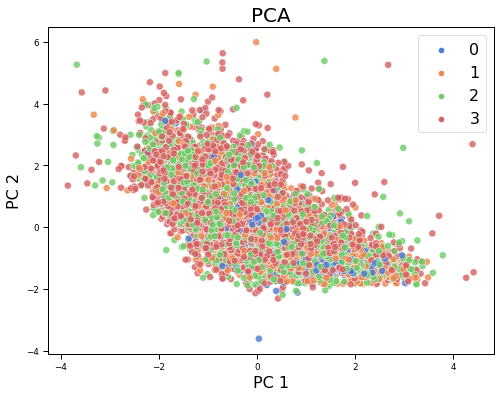

In [202]:
plt.figure(figsize=(8,6))
#sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 
plot = sns.scatterplot(data=pca_df, x="PC 1", y="PC 2", hue=df.steps_bins, alpha=0.8, palette='muted', s=50).set_title(
   'PCA', fontsize=20)
#plt.legend(fontsize='16', title_fontsize='16')
print('shape: ', scaled_df_2.shape)

In [204]:
fps_tsne = TSNE(n_components=2, perplexity=50, init='pca', learning_rate='auto', random_state=1).fit_transform(scaled_df_2)

/home/zumrovad/.conda/envs/az/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


shape:  (15918, 2)


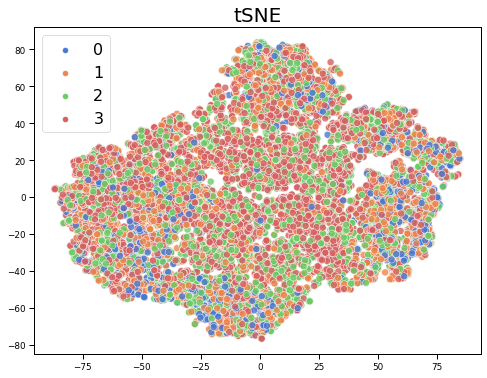

In [205]:
plt.figure(figsize=(8,6))
plot = sns.scatterplot(x=fps_tsne[:,0], y=fps_tsne[:,1], hue=df['steps_bins'], palette='muted',alpha=0.8,s=50).set_title('tSNE')
#plot = sns.scatterplot(x=fps_tsne[:,0], y=fps_tsne[:,1], hue=df['steps_bins'], palette='muted', alpha=0.8, s=50).set_title(
#    'tSNE', fontsize=20)
#plt.legend(fontsize='16', title_fontsize='16')
print('shape: ', fps_tsne.shape)

In [18]:
def cross_scoring(model, X, Y):
    score = {'r2':'r2',
         'MAE':'neg_mean_absolute_error',
         'MSE':'neg_mean_squared_error',
         'RMSE':'neg_root_mean_squared_error'}
    scores = cross_validate(model, X, Y, scoring=score, cv=10)
    return scores

In [19]:
def best_param(x,y):
    #RFR
    RFR = RandomForestRegressor(random_state=0)
    params = { 'max_depth': [8, 15, 20, None],
               'max_features': [1.0, 'sqrt'],
               'n_estimators': [200, 400, 800, 1000]}
    search = GridSearchCV(RFR, params, scoring='neg_mean_squared_error', cv=10)
    results_RFR = search.fit(x, y)
    return -results_RFR.best_score_, results_RFR.best_params_
    #print('Best MSE: %0.3f' % -results_RFR.best_score_)
    #print('Best Hyperparameters: %s' % results_RFR.best_params_)

### All generated data

In [382]:
y = np.array(df.steps_bins)
y_steps = np.array(df.number_of_steps)
x = np.array(df[['syba', 'sascore', 'scscore', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']])

In [383]:
score, params = best_param(x,y)

Best MSE: 6.731
Best Hyperparameters: {'max_depth': 8, 'n_estimators': 200}


In [ ]:
print('Best MSE: %0.3f' % score)
print('Best Hyperparameters: %s' % params)

In [386]:
RFR = RandomForestRegressor(random_state=0, max_depth=8, n_estimators=200)

In [388]:
score_df = cross_scoring(RFR, x, y)
score_df_steps = cross_scoring(RFR, x, y_steps)

In [391]:
score_df_bin2 = cross_scoring(RFR, x, np.array(df.steps_bins2))

In [392]:
print("r2 %0.3f (+/- %0.3f)" % (score_df_bin2['test_r2'].mean(), score_df_bin2['test_r2'].std()))
print("MAE %0.3f (+/- %0.3f)" % (-score_df_bin2['test_MAE'].mean(), score_df_bin2['test_MAE'].std()))
print("MSE %0.3f (+/- %0.3f)" % (-score_df_bin2['test_MSE'].mean(), score_df_bin2['test_MSE'].std()))
print("RMSE %0.3f (+/- %0.3f)" % (-score_df_bin2['test_RMSE'].mean(), score_df_bin2['test_RMSE'].std()))

r2 0.177 (+/- 0.050)
MAE 0.825 (+/- 0.031)
MSE 0.952 (+/- 0.064)
RMSE 0.975 (+/- 0.033)


### After scaffold filter

In [436]:
y_new = np.array(df_new.steps_bins)
y_new_steps = np.array(df_new.number_of_steps)
x_new = np.array(df_new[['syba', 'sascore', 'scscore', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']])

In [ ]:
s_new, p_new = best_param(x_new, y_new)

In [ ]:
print('Best MSE: %0.3f' % s_new)
print('Best Hyperparameters: %s' % p_new)

In [397]:
RFR = RandomForestRegressor(random_state=0, max_depth=8, n_estimators=250)

In [398]:
score_df_new = cross_scoring(RFR, x_new, y_new)
score_df_new_steps = cross_scoring(RFR, x_new, y_new_steps)

In [254]:
# After similarity filter
y_d = np.array(d.steps_bins)
x_d = np.array(d[['syba', 'sascore', 'scscore', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']])
cross = cross_val_score(RFR, x_d, y_d, scoring='neg_mean_squared_error', cv=10)
print("MSE %0.3f (+/- %0.3f)" % (-cross.mean(), cross.std()))

MSE 1.078 (+/- 0.797)


In [253]:
# After scaffold and similarity filter
y_sim = np.array(df_sim.steps_bins)
x_sim = np.array(df_sim[['syba', 'sascore', 'scscore', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']])
cross = cross_val_score(RFR, x_sim, y_sim, scoring='neg_mean_squared_error', cv=10)
print("MSE %0.3f (+/- %0.3f)" % (-cross.mean(), cross.std()))

MSE 1.071 (+/- 0.775)


## Prediction Denis data

In [290]:
df1 = pd.read_csv('data/Denis_final_data_after_pipeline.csv')
df1 = df1[df1.steps > 0]
df1 = df1[df1.steps <= 10]
df1 = df1.drop_duplicates(subset=['smiles'])
df1 = df1.drop(columns=['orig_smiles','orig_index','is_solved','pipeline_status','syba_score'])

In [293]:
mols1 = [Chem.MolFromSmiles(smile) for smile in df1.smiles]
df1['mol'] = mols1
df1['MolWt'] = df1.mol.apply(Descriptors.MolWt)
df1['MolLogP'] = df1.mol.apply(Descriptors.MolLogP)
df1['NumHAccept'] = df1.mol.apply(Descriptors.NumHAcceptors)
df1['NumHDonors'] = df1.mol.apply(Descriptors.NumHDonors)
df1['steps_bins'] = pd.cut(df1['steps'], [0,1,3,6,10], labels=False) #, labels=False

In [299]:
y1 = np.array(df1.steps_bins)
y1_steps = np.array(df1.steps)
x1 = np.array(df1[['syba', 'sa', 'sc', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']])

In [301]:
score_df1 = cross_scoring(RFR, x1, y1)
score_df1_steps = cross_scoring(RFR, x1, y1_steps)

In [302]:
print("r2 %0.3f (+/- %0.3f)" % (score_df1['test_r2'].mean(), score_df1['test_r2'].std()))
print("MAE %0.3f (+/- %0.3f)" % (-score_df1['test_MAE'].mean(), score_df1['test_MAE'].std()))
print("MSE %0.3f (+/- %0.3f)" % (-score_df1['test_MSE'].mean(), score_df1['test_MSE'].std()))
print("RMSE %0.3f (+/- %0.3f)" % (-score_df1['test_RMSE'].mean(), score_df1['test_RMSE'].std()))

r2 0.352 (+/- 0.072)
MAE 0.627 (+/- 0.078)
MSE 0.650 (+/- 0.108)
RMSE 0.803 (+/- 0.067)


In [303]:
print("r2 %0.3f (+/- %0.3f)" % (score_df1_steps['test_r2'].mean(), score_df1_steps['test_r2'].std()))
print("MAE %0.3f (+/- %0.3f)" % (-score_df1_steps['test_MAE'].mean(), score_df1_steps['test_MAE'].std()))
print("MSE %0.3f (+/- %0.3f)" % (-score_df1_steps['test_MSE'].mean(), score_df1_steps['test_MSE'].std()))
print("RMSE %0.3f (+/- %0.3f)" % (-score_df1_steps['test_RMSE'].mean(), score_df1_steps['test_RMSE'].std()))

r2 0.301 (+/- 0.065)
MAE 1.652 (+/- 0.362)
MSE 5.002 (+/- 1.451)
RMSE 2.213 (+/- 0.326)


# Comparison

In [375]:
d1 = pd.DataFrame.from_dict(score_df1_steps)
d1['data']='control'
d2 = pd.DataFrame.from_dict(score_df_steps)
d2['data']='balanced'
d3 = pd.DataFrame.from_dict(score_df_new_steps)
d3['data']='balanced&filtered'

In [376]:
frames = [d1,d2,d3]
df_scores = pd.concat(frames)

In [377]:
df_scores['test_MSE'] = -1*df_scores['test_MSE']
df_scores['test_MAE'] = -1*df_scores['test_MAE']
df_scores['test_RMSE'] = -1*df_scores['test_RMSE']

Text(0.5, 1.0, 'RMSE')

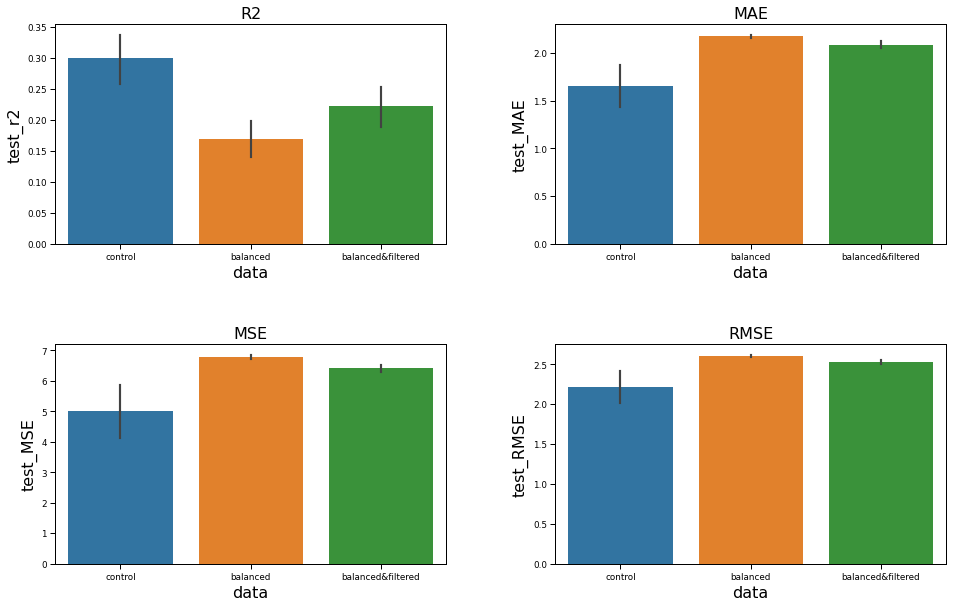

In [378]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.tight_layout(pad=5.0)
sns.barplot(ax=axes[0,0], data=df_scores, x="data", y="test_r2")
axes[0,0].set_title('R2')
sns.barplot(ax=axes[0,1], data=df_scores, x="data", y="test_MAE")
axes[0,1].set_title('MAE')
sns.barplot(ax=axes[1,0], data=df_scores, x="data", y="test_MSE")
axes[1,0].set_title('MSE')
sns.barplot(ax=axes[1,1], data=df_scores, x="data", y="test_RMSE")
axes[1,1].set_title('RMSE')

In [402]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new_steps, random_state=1)

In [403]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(x1, y1_steps, random_state=1)

In [404]:
RFR = RandomForestRegressor(random_state=0, max_depth=8, n_estimators=250)

In [405]:
RFR.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, n_estimators=250, random_state=0)

In [406]:
RFR.fit(X_train1, y_train1)

RandomForestRegressor(max_depth=8, n_estimators=250, random_state=0)

In [407]:
RFR_fit = RFR.fit(X_train, y_train)
predict = RFR_fit.predict(X_test)
predict_r = np.array([round(y) for y in predict])

In [408]:
RFR_fit1 = RFR.fit(X_train1, y_train1)
predict1 = RFR_fit1.predict(X_test1)
predict_r1 = np.array([round(y) for y in predict1])

In [409]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix, ConfusionMatrixDisplay

In [410]:
print('f1: %0.3f' % f1_score(y_test, predict_r, average='weighted'))
print('Accuracy: %0.3f' % accuracy_score(y_test, predict_r))
print('Recall: %0.3f' % recall_score(y_test, predict_r, average='weighted'))
print('Precision: %0.3f' % precision_score(y_test, predict_r, average='weighted', zero_division=0))
print('MSE: %0.3f' %  mean_squared_error(y_test, predict))
print('MAE: %0.3f' % mean_absolute_error(y_test, predict))
print('R2: %0.3f' % r2_score(y_test, predict))

f1: 0.100
Accuracy: 0.127
Recall: 0.127
Precision: 0.112
MSE: 6.287
MAE: 2.080
R2: 0.302


In [411]:
print('f1: %0.3f' % f1_score(y_test1, predict_r1, average='weighted'))
print('Accuracy: %0.3f' % accuracy_score(y_test1, predict_r1))
print('Recall: %0.3f' % recall_score(y_test1, predict_r1, average='weighted'))
print('Precision: %0.3f' % precision_score(y_test1, predict_r1, average='weighted', zero_division=0))
print('MSE: %0.3f' %  mean_squared_error(y_test1, predict1))
print('MAE: %0.3f' % mean_absolute_error(y_test1, predict1))
print('R2: %0.3f' % r2_score(y_test1, predict1))

f1: 0.281
Accuracy: 0.259
Recall: 0.259
Precision: 0.379
MSE: 4.819
MAE: 1.618
R2: 0.456


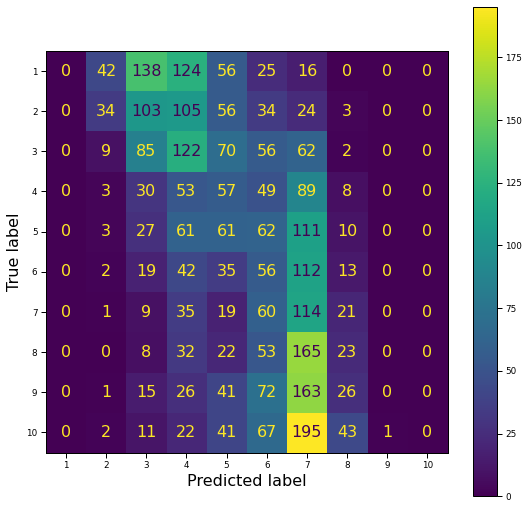

In [434]:
#plt.figure(figsize=(15,15))
fig, ax = plt.subplots(figsize=(9, 9))
ConfusionMatrixDisplay.from_predictions(y_test, predict_r, ax=ax)
plt.show()

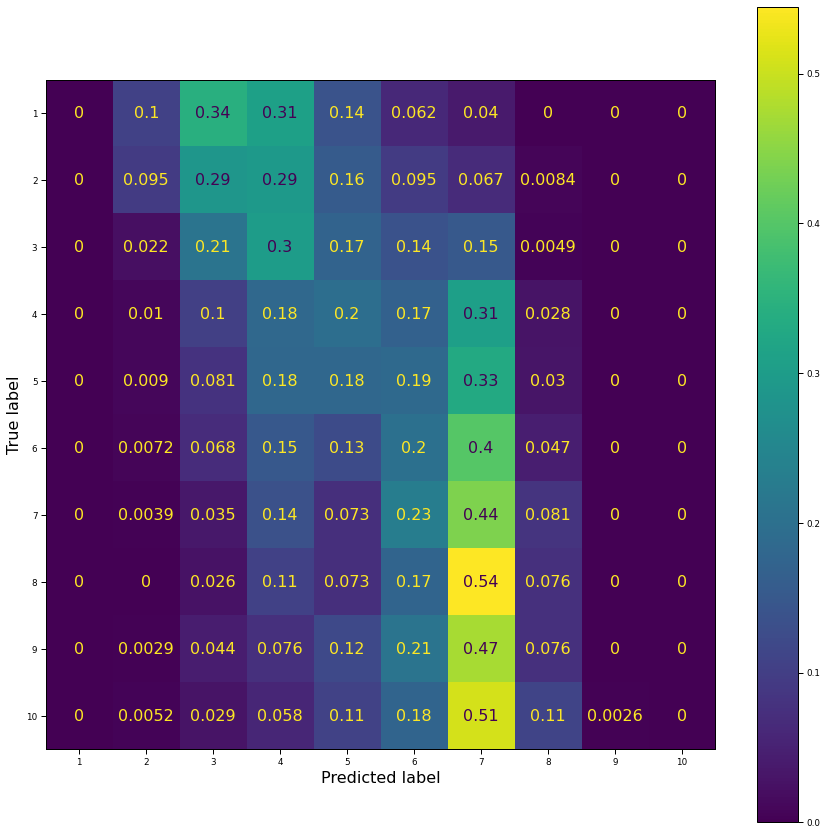

In [431]:
#plt.figure(figsize=(15,15))
fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(y_test, predict_r, ax=ax, normalize = 'true')
plt.show()

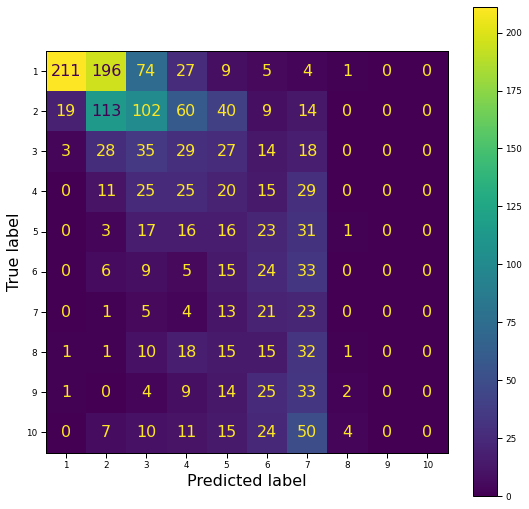

In [435]:
fig, ax = plt.subplots(figsize=(9, 9))
ConfusionMatrixDisplay.from_predictions(y_test1, predict_r1, ax=ax)
plt.show()

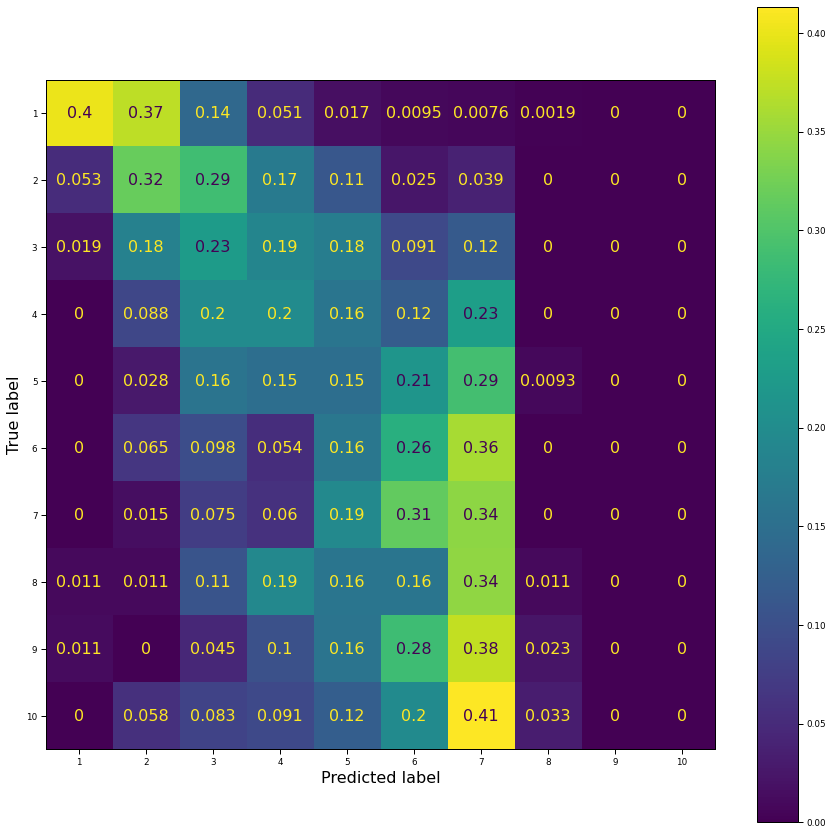

In [432]:
fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(y_test1, predict_r1, ax=ax, normalize = 'true')
plt.show()

# AUC